In [1]:
import Pkg; Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


# Monte Carlo Wavefunction Method

In [2]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads

# Example 1: Radiative Damping

Here we consider the (base) jumps and hamiltonian:
$$ H = \frac{\Delta\omega}{2}\sigma_z $$
$$ L = \sqrt{\gamma}\sigma_- $$

with a $T$ parametrization and coherent fields

In [3]:
Tid = 1/sqrt(2) * [1 1im; 1 1im]
function rotation_matrix(theta)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R
end
ntimes = 200
params = BackAction.rd_params;
t_eval = collect(LinRange(0.0, params.tf, ntimes));

In [4]:
function get_z_sample(theta)
    T = rotation_matrix(theta)*Tid#reshape([1.0 + 0.0im], 1,1)
    alphas = [3.3 + 0.0im; 3.3 + 0.0im]
    sys = System(BackAction.rd_H, [BackAction.rd_L], T, alphas)
    sim = get_sol_jumps(sys, params, t_eval)
    z_sample = Array{Float64}(undef, ntimes, params.ntraj)
    @threads for n in 1:params.ntraj
                 for t in 1:ntimes
                     psi = sim[n](t_eval[t])
                     z_sample[t, n] = real(dot(psi, BackAction.sigma_z, psi))/dot(psi, psi)
                 end
    end 
    return z_sample
end 

get_z_sample (generic function with 1 method)

In [5]:
z_sample1 = get_z_sample(1.5);
z_sample2 = get_z_sample(1.8);
z_sample3 = get_z_sample(0.8);

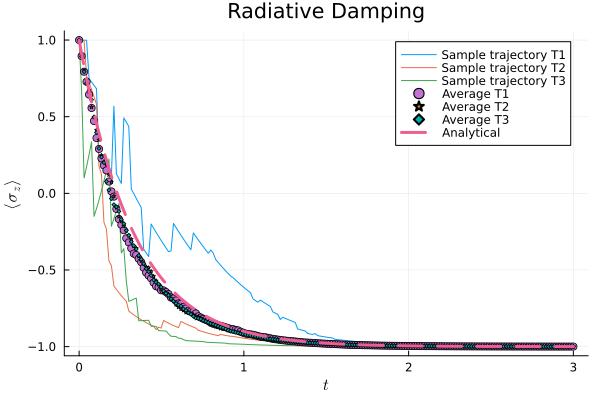

In [6]:
plot(t_eval, z_sample1[:, 1], label="Sample trajectory T1", xlabel=L"t", ylabel=L"\langle\sigma_z\rangle", title="Radiative Damping")
plot!(t_eval, z_sample2[:, 2], label="Sample trajectory T2")
plot!(t_eval, z_sample3[:, 3], label="Sample trajectory T3")
scatter!(t_eval, dropdims(mean(z_sample1, dims=2), dims=2), label="Average T1")
scatter!(t_eval, dropdims(mean(z_sample2, dims=2), dims=2), label="Average T2", markersize=2, markershape=:star)
scatter!(t_eval, dropdims(mean(z_sample3, dims=2), dims=2), label="Average T3", markersize=2, markershape=:diamond)
plot!(t_eval, t -> 2*exp(-BackAction.rd_gamma*t) - 1, label="Analytical", linewidth=3, line=:dash)

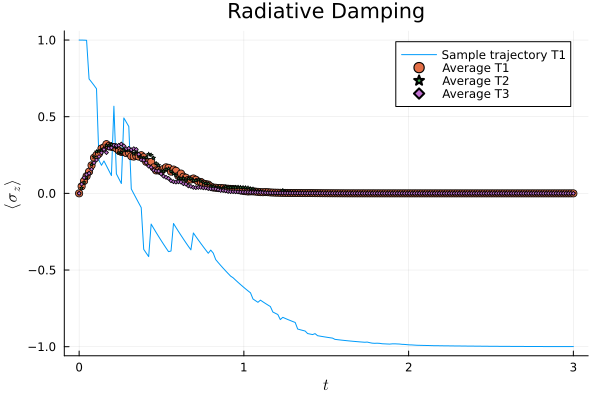

In [7]:
plot(t_eval, z_sample1[:, 1], label="Sample trajectory T1", xlabel=L"t", ylabel=L"\langle\sigma_z\rangle", title="Radiative Damping")
scatter!(t_eval, dropdims(var(z_sample1, dims=2), dims=2), label="Average T1")
scatter!(t_eval, dropdims(var(z_sample2, dims=2), dims=2), label="Average T2", markersize=2, markershape=:star)
scatter!(t_eval, dropdims(var(z_sample3, dims=2), dims=2), label="Average T3", markersize=2, markershape=:diamond)

# Example 2: Driven Qubit


In [8]:
function su2_matrix(theta, phi, psi)
    return [exp(1im*phi)*cos(theta) exp(1im*psi)*sin(theta); -exp(-1im*psi)*sin(theta) exp(-1im*phi)*cos(theta)]
end 

su2_matrix (generic function with 1 method)

In [9]:
# Parameters and time evaluation
ntimes = 75
params = SimulParameters([1.0+0im; 0.0], #initial condition
    25.0, #tf
    1, # seed
    1_000, # Number of trajectories
    # You can ignore the rest, they are only used for the Gillipsie method
    25_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
t_eval = collect(LinRange(0.0, params.tf, ntimes));
gamma = 1.0
delta = 0.5
omega = 0.5
nbar= 0.0

H = 0.5*delta*BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
L1 = sqrt(gamma*(nbar+1))*BackAction.sigma_m
L2 = sqrt(gamma*(nbar))*BackAction.sigma_p
T1 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
T2 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
T3 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
alphas = [1.0 + 0.0im; 1.0 + 0.0im]

 

2-element Vector{ComplexF64}:
 1.0 + 0.0im
 1.0 + 0.0im

In [10]:
function generate_trajectory_ensemble(T)
    sys = System(H, [L1, L2], T, alphas)
    # Problem definition
    @time begin
    sim = get_sol_jumps(sys, params, t_eval);
    end
    return sim
end 

function get_r_sample(sim)
    # observable evaluation 
    r_sample = Array{Float64}(undef, 3, ntimes,params.ntraj)
    sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]
    @threads for n in 1:params.ntraj
                 for t in 1:ntimes
                    psi = sim[n](t_eval[t])
                    for k in 1:3
                        r_sample[k, t, n] = real(dot(psi, sigma[k], psi))/dot(psi, psi)
                     end
                 end 
            end 
    return r_sample
end

get_r_sample (generic function with 1 method)

In [11]:
# Parameters definition and problem initialization
sim1 = generate_trajectory_ensemble(T1)
sim2 = generate_trajectory_ensemble(T2)
sim3 = generate_trajectory_ensemble(T3)
r_sample1 = get_r_sample(sim1);
r_sample2 = get_r_sample(sim2);
r_sample3 = get_r_sample(sim3);

  2.539787 seconds (38.38 M allocations: 3.297 GiB, 55.36% gc time)
  2.087408 seconds (48.41 M allocations: 4.150 GiB, 36.02% gc time)
  2.082314 seconds (35.08 M allocations: 3.015 GiB, 46.08% gc time)


In [12]:
# Analytical solution
function resonance_fluorescene!(du, u, p, t)
    #     -0.5*gamma*(2*nbar+1)*r[1] - delta*r[2]
    # delta*r[1] - 0.5*gamma*(2*nbar+1)*r[2] - omega*r[3];
    # omega*r[2] - gamma*(2*nbar+1)*r[3] - gamma]

    du[1] = - 0.5*gamma*(2*nbar+1)*u[1] - delta*u[2]  
    du[2] = + delta*u[1] - 0.5*gamma*(2*nbar+1)*u[2]- omega*u[3]  
    du[3] = omega*u[2] - gamma*(2*nbar+1)*u[3] - gamma
end
u0 = [0.0, 0.0, -1.0]
prob_analytical = ODEProblem(resonance_fluorescene!, u0, extrema(t_eval))
sol_analytical = solve(prob_analytical);

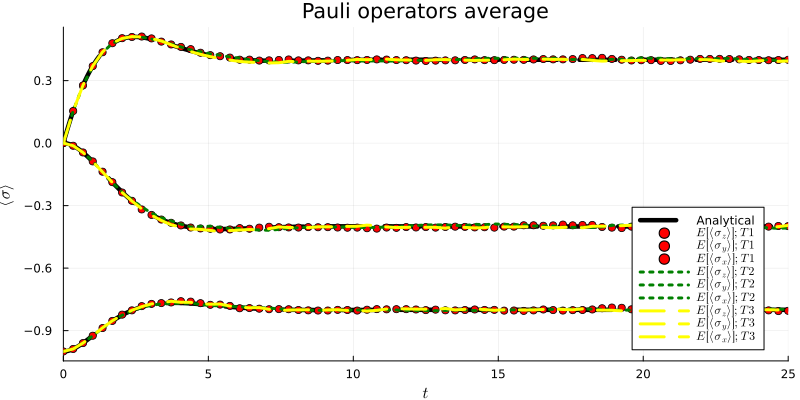

In [13]:
# Analytical
plot(sol_analytical, idxs=(0,3), label="Analytical", color="black", line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,2), label=false, color="black",line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,1), label=false, color="black",line=:dash, linewidth=4.5)
# T1
scatter!(t_eval, dropdims(mean(r_sample1[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T1", linewidth=3.0, color="red",
    title="Pauli operators average", size=(800, 400))
scatter!(t_eval, dropdims(mean(r_sample1[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T1", linewidth=3, color="red",
        )
scatter!(t_eval, dropdims(mean(r_sample1[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T1", linewidth=3, color="red",
        )
# T2
plot!(t_eval, dropdims(mean(r_sample2[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T2", linewidth=3, color="green",
    line=:dot)
plot!(t_eval, dropdims(mean(r_sample2[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T2", linewidth=3, color="green",
    line=:dot)
plot!(t_eval, dropdims(mean(r_sample2[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T2", linewidth=3, color="green",
    line=:dot)
#T3
plot!(t_eval, dropdims(mean(r_sample3[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T3", linewidth=3, color="yellow",
     line=:dash)
plot!(t_eval, dropdims(mean(r_sample3[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T3", linewidth=3, color="yellow",
    line=:dash)
plot!(t_eval, dropdims(mean(r_sample3[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T3", linewidth=3, color="yellow",
    line=:dash, xlabel=L"t", ylabel=L"\langle\sigma\rangle")

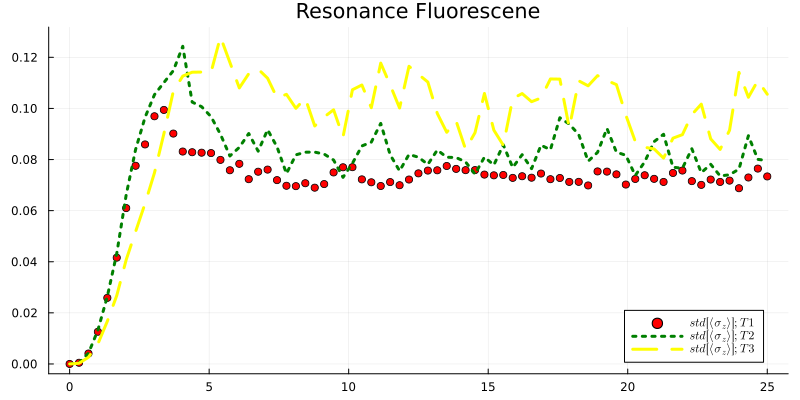

In [9]:
# T1
scatter(t_eval, dropdims(std(r_sample1[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T1", linewidth=3.0, color="red",
    title="Resonance Fluorescene", size=(800, 400))
#scatter!(t_eval, dropdims(std(r_sample1[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T1", linewidth=3, color="red",
#        )
#scatter(t_eval, dropdims(var(r_sample1[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T1", linewidth=3, color="red",
#        title="Variance ")
# T2
plot!(t_eval, dropdims(std(r_sample2[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T2", linewidth=3, color="green",
    title="Resonance Fluorescene", size=(800, 400), line=:dot)
#plot!(t_eval, dropdims(std(r_sample2[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T2", linewidth=3, color="green",
#    line=:dot)
#plot!(t_eval, dropdims(var(r_sample2[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T2", linewidth=3, color="green",
#    line=:dot)
#T3
plot!(t_eval, dropdims(std(r_sample3[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T3", linewidth=3, color="yellow",
    title="Resonance Fluorescene", size=(800, 400), line=:dash)
#plot!(t_eval, dropdims(std(r_sample3[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T3", linewidth=3, color="yellow",
#    line=:dash)
#plot!(t_eval, dropdims(var(r_sample3[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T3", linewidth=3, color="yellow",
#    line=:dash, xlabel=L"t", ylabel=L"Var\langle\sigma\rangle")

# Testing the trajectory saving

In [11]:
# System and parameters
H = (delta::Float64, omega::Float64, k::Float64) ->  delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*BackAction.sigma_x
L = (delta::Float64, omega::Float64, k::Float64) -> sqrt(k)*BackAction.sigma_m
He = BackAction.getheff_parametrized(H, [L])
delta = 0.3
omega = 1.0
k = 0.5
sys = System(H(delta, omega, k), # Hamiltonian
             [L(delta, omega, k)]) #Jump Operators
tf = 300.0
params = SimulParameters(BackAction.rf_psi0,
                         tf, # Final time. Set very long so that all trajectories jump
                         1, # seed
                         1000, # Number of trajectories
                         30_000, # Number of samples in the finegrid
                         1.0, # Multiplier to use in the fine grid
                         1e-3 # Tolerance for passing Dark state test
                         )
ntimes = 1000
t_eval = collect(LinRange(0.0, params.tf, ntimes));
@time begin
sim = get_sol_jumps(sys, params, t_eval);
end 

  5.350079 seconds (118.38 M allocations: 10.077 GiB, 39.69% gc time, 0.11% compilation time)


EnsembleSolution Solution of length 1000 with uType:
ODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, Nothing, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, BackAction.var"#f!#19"{System}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, System, Nothing, Nothing}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol}, @NamedTuple{callback::ContinuousCallback{BackAction.var"#condition#20"{BackAction._LindbladJump{Vector{Matrix{ComplexF64}}, Matrix{ComplexF64}, MersenneTwister, Base.RefValue{Float64}, Vector{Float64}, Vector{ComplexF64}, Vector{Float64}, Vector{Int64}, Base.RefValue{Int64}}}, BackAction._LindbladJump{Vector{Matrix{ComplexF64}}, Matrix{ComplexF64}, MersenneTwister, Base.RefValue{Float64}, Vector{Float64

In [14]:
function resonance_fluorescene!(du, u, p, t)
    #     -0.5*gamma*(2*nbar+1)*r[1] - delta*r[2]
    # delta*r[1] - 0.5*gamma*(2*nbar+1)*r[2] - omega*r[3];
    # omega*r[2] - gamma*(2*nbar+1)*r[3] - gamma]
    nbar = 0.0
    du[1] = - 0.5*k*(2*nbar+1)*u[1] - delta*u[2]  
    du[2] = + delta*u[1] - 0.5*k*(2*nbar+1)*u[2]- omega*u[3]  
    du[3] = omega*u[2] - k*(2*nbar+1)*u[3] - k
end
u0 = [0.0, 0.0, -1.0]
prob_analytical = ODEProblem(resonance_fluorescene!, u0, extrema(t_eval))
sol_analytical = solve(prob_analytical);

In [ ]:
# Trajectory extraction
"From the solution, obtain the trajectory"
function extract_trajectory(sol)
    times = sol.prob.kwargs[:callback].affect!.jump_times
    channels = sol.prob.kwargs[:callback].affect!.jump_channels
    njumps = length(times)
    traj = Vector{DetectionClick}(undef, njumps)
    @inbounds for k in 1:njumps   
       traj[k] = DetectionClick(times[k], channels[k]) 
    end  
    return traj
end

In [17]:
data = Vector{Trajectory}(undef, params.ntraj)
for k in 1:params.ntraj
    data[k] = extract_trajectory(sim[k])
end 

In [19]:
data[1]

52-element Vector{DetectionClick}:
 DetectionClick(7.771735919091841, 1)
 DetectionClick(12.43154039507852, 1)
 DetectionClick(15.846865491217454, 1)
 DetectionClick(16.998626568591582, 1)
 DetectionClick(24.331318840288162, 1)
 DetectionClick(27.43338236456524, 1)
 DetectionClick(31.18931749141298, 1)
 DetectionClick(36.44356359405659, 1)
 DetectionClick(43.786012957860684, 1)
 DetectionClick(48.865087729588076, 1)
 DetectionClick(62.03883015948439, 1)
 DetectionClick(63.721908914358174, 1)
 DetectionClick(65.99024750075743, 1)
 ⋮
 DetectionClick(233.41924719245335, 1)
 DetectionClick(236.3669274801078, 1)
 DetectionClick(237.5075473494934, 1)
 DetectionClick(242.07771973991547, 1)
 DetectionClick(245.66729424681682, 1)
 DetectionClick(253.6803223600776, 1)
 DetectionClick(258.3872026225417, 1)
 DetectionClick(267.8528540019437, 1)
 DetectionClick(278.9269711424711, 1)
 DetectionClick(281.1472677904885, 1)
 DetectionClick(290.7841628616166, 1)
 DetectionClick(293.1017258046053, 1)

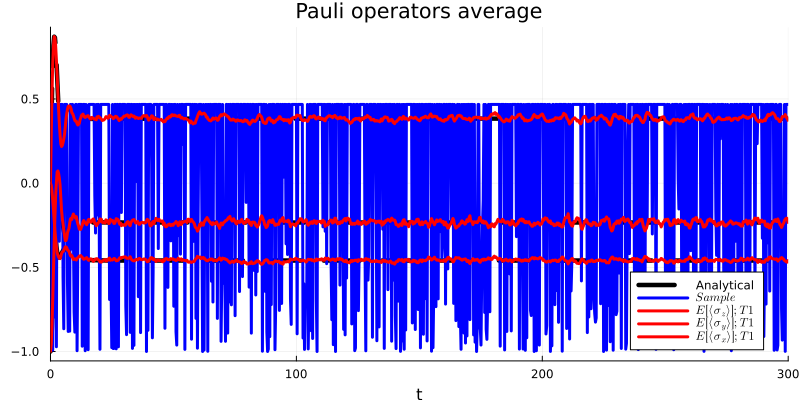

In [29]:
r_sample = get_r_sample(sim)

# Analytical
plot(sol_analytical, idxs=(0,3), label="Analytical", color="black", line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,2), label=false, color="black",line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,1), label=false, color="black",line=:dash, linewidth=4.5)
# Sample trajectory
plot!(t_eval, r_sample[3, 10, :], label=L"Sample", linewidth=3.0, color="blue")
## T1
plot!(t_eval, dropdims(mean(r_sample[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T1", linewidth=3.0, color="red",
    title="Pauli operators average", size=(800, 400))
plot!(t_eval, dropdims(mean(r_sample[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T1", linewidth=3, color="red",
        )
plot!(t_eval, dropdims(mean(r_sample[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T1", linewidth=3, color="red",
        )
#plot(t_eval, r_sample[1, 1, :])

In [23]:
function GetFI(delta::Float64, ntraj::Int64)
   trajectories = Vector{Trajectory}(undef, ntraj)
    for k in 1:ntraj
       trajectories[k] = extract_trajectory(sim[k]) 
    end 
    ntimes = size(t_given)[1]
    xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
    @time begin
    for n in 1:params.ntraj
        xi_sample[:, :, :, n] = monitoringoperator(t_given, sys, He, [L], trajectories[n],
                                                   params.psi0,[delta, omega, k], [delta/100, 0.0, 0.0])
    end
    end
    fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
    for n in 1:params.ntraj
        for k in 1:ntimes
            fi_sample[k, n] = real(tr(xi_sample[:, :, k, n]))^2
        end
    end
    return fi_sample./tf
end

GetFI (generic function with 1 method)

In [3]:
delta_gammelmark = 0.2/0.478 * [0.146,0.262,0.383,0.511,0.648,0.806,0.965,1.118,1.287,1.438,1.596,
                                1.755,1.888, 2.057, 2.206, 2.381, 2.539, 2.682, 2.865, 3.013, 3.174, 3.334, 3.452]

23-element Vector{Float64}:
 0.06108786610878661
 0.10962343096234312
 0.16025104602510462
 0.21380753138075317
 0.27112970711297074
 0.3372384937238494
 0.40376569037656906
 0.4677824267782428
 0.5384937238493724
 0.601673640167364
 0.6677824267782427
 0.7343096234309624
 0.7899581589958159
 0.8606694560669457
 0.9230125523012553
 0.996234309623431
 1.0623430962343097
 1.1221757322175734
 1.198744769874477
 1.2606694560669456
 1.3280334728033474
 1.394979079497908
 1.4443514644351465

In [20]:
delta_gammelmark = 0.2/0.478 * [0.146,0.262,0.383,0.511,0.648,0.806,0.965,1.118,1.287,1.438,1.596,
                                1.755,1.888, 2.057, 2.206, 2.381, 2.539, 2.682, 2.865, 3.013, 3.174, 3.334, 3.452]
fi_t_gammelmark = [0.115, 0.221, 0.338, 0.425, 0.507, 0.557, 0.573, 0.566, 0.532, 0.494,
                   0.448, 0.403, 0.363, 0.318, 0.281, 0.241, 0.210, 0.186, 0.156, 0.137, 0.115, 0.101, 0.09348]


@testset "Gammelmark-Molmer (2014): Fisher Information of Delta" begin
    ntraj = 1000
    fi_samples = Array{Float64}(undef, ntraj, size(delta_gammelmark)[1])
    @showprogress for delta_index in 1:size(delta_gammelmark)[1]
        fi_samples[:, delta_index] = GetFI(delta_gammelmark[delta_index], ntraj)
    end
    my_fi_t = dropdims(mean(fi_samples, dims=1), dims=1)
    # Check that all the differences to their data are wihtin tolerance
    for k in 1:size(delta_gammelmark)[1]
        @test abs(my_fi_t[k] - fi_t_gammelmark[k]) < 0.05
    end
end



  0.070960 seconds (288.14 k allocations: 62.437 MiB)
  0.034166 seconds (211.00 k allocations: 16.388 MiB)
  0.077657 seconds (288.26 k allocations: 62.447 MiB)
  0.029638 seconds (211.00 k allocations: 16.388 MiB)


Progress:   9%|███▋                                     |  ETA: 0:00:19

  0.067963 seconds (288.14 k allocations: 62.437 MiB)
  0.031550 seconds (211.00 k allocations: 16.388 MiB)
  0.062146 seconds (288.14 k allocations: 62.437 MiB)
  0.032352 seconds (211.00 k allocations: 16.388 MiB)
  0.058080 seconds (288.14 k allocations: 62.437 MiB)
  0.086199 seconds (211.00 k allocations: 16.388 MiB, 62.32% gc time)
  0.059682 seconds (288.14 k allocations: 62.437 MiB)
  0.032082 seconds (211.00 k allocations: 16.388 MiB)
  0.054303 seconds (288.26 k allocations: 62.447 MiB)
  0.032384 seconds (211.00 k allocations: 16.388 MiB)


Progress:  35%|██████████████▎                          |  ETA: 0:00:06

  0.050046 seconds (288.26 k allocations: 62.447 MiB)
  0.043594 seconds (211.00 k allocations: 16.388 MiB)


Progress:  39%|████████████████                         |  ETA: 0:00:05

  0.122538 seconds (288.26 k allocations: 62.447 MiB, 46.84% gc time)
  0.032065 seconds (211.00 k allocations: 16.388 MiB)


Progress:  43%|█████████████████▉                       |  ETA: 0:00:04

  0.066024 seconds (288.26 k allocations: 62.447 MiB)
  0.036420 seconds (211.00 k allocations: 16.388 MiB)


Progress:  48%|███████████████████▋                     |  ETA: 0:00:04

  0.060528 seconds (288.26 k allocations: 62.447 MiB)
  0.044004 seconds (211.00 k allocations: 16.388 MiB)
  0.054889 seconds (288.26 k allocations: 62.447 MiB)
  0.096345 seconds (211.00 k allocations: 16.388 MiB, 52.39% gc time)


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:03

  0.064377 seconds (288.14 k allocations: 62.437 MiB)
  0.032506 seconds (211.00 k allocations: 16.388 MiB)


Progress:  61%|█████████████████████████                |  ETA: 0:00:02

  0.053168 seconds (288.26 k allocations: 62.447 MiB)
  0.032006 seconds (211.00 k allocations: 16.388 MiB)
  0.054607 seconds (288.14 k allocations: 62.437 MiB)
  0.036896 seconds (211.00 k allocations: 16.388 MiB)


Progress:  70%|████████████████████████████▌            |  ETA: 0:00:02

  0.108018 seconds (288.14 k allocations: 62.437 MiB, 45.14% gc time)
  0.030181 seconds (211.00 k allocations: 16.388 MiB)
  0.057616 seconds (288.14 k allocations: 62.437 MiB)
  0.030866 seconds (211.00 k allocations: 16.388 MiB)


Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:01

  0.054910 seconds (288.14 k allocations: 62.437 MiB)
  0.032678 seconds (211.00 k allocations: 16.388 MiB)
  0.055511 seconds (288.26 k allocations: 62.447 MiB)
  0.094984 seconds (211.00 k allocations: 16.388 MiB, 54.96% gc time)


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:01

  0.055665 seconds (288.14 k allocations: 62.437 MiB)
  0.043640 seconds (211.00 k allocations: 16.388 MiB)


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:01

  0.059730 seconds (288.14 k allocations: 62.437 MiB)
  0.058308 seconds (211.00 k allocations: 16.388 MiB)


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:00

  0.061082 seconds (288.14 k allocations: 62.437 MiB)
  0.046681 seconds (211.00 k allocations: 16.388 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  0.118524 seconds (288.14 k allocations: 62.437 MiB, 45.46% gc time)
  0.033824 seconds (211.00 k allocations: 16.388 MiB)
Gammelmark-Molmer (2014): Fisher Information of Delta: Test Failed at In[20]:16
  Expression: abs(my_fi_t[k] - fi_t_gammelmark[k]) < 0.05
   Evaluated: 19.94292072906299 < 0.05

Stacktrace:
  [1] macro expansion
    @ ~/julia/share/julia/stdlib/v1.10/Test/src/Test.jl:672 [inlined]
  [2] macro expansion
    @ ./In[20]:16 [inlined]
  [3] macro expansion
    @ ~/julia/share/julia/stdlib/v1.10/Test/src/Test.jl:1577 [inlined]
  [4] top-level scope
    @ ./In[20]:8
  [5] eval
    @ ./boot.jl:385 [inlined]
  [6] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
    @ Base ./loading.jl:2146
  [7] softscope_include_string(m::Module, code::String, filename::String)
    @ SoftGlobalScope ~/.julia/packages/SoftGlobalScope/u4UzH/src/SoftGlobalScope.jl:65
  [8] execute_request(socket::ZMQ.Socket, msg::IJulia.Msg)
    @ IJulia ~/.julia/

LoadError: [91mSome tests did not pass: 0 passed, 23 failed, 0 errored, 0 broken.[39m